# Neural Network mapping to learn MODIS LST from ERA features

### Set up tensorflow environment

In [1]:
import tensorflow as tf
import os
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-03-28 14:51:07.928458: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 14:51:12.321976: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:214] Using CUDA malloc Async allocator for GPU: 0
2022-03-28 14:51:12.323212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0


### Load and normalise data from the off

In [1]:
import pandas as pd
print('Loading the data')
#input_file = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS_ERA_joined_data_averaged.pkl'
input_file = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ML_data_ERA_MODIS_joined.pkl'
df = pd.read_pickle(input_file)



Loading the data


In [2]:
# Split into meta/features/targets 

feature_names = [ 'sp', 'msl', 'u10', 'v10','t2m',
                         'aluvp', 'aluvd', 'alnip', 'alnid', 'cl',
                         'cvl', 'cvh', 'slt', 'sdfor', 'z', 'sd', 'sdor', 'isor', 'anor', 'slor',
                         'd2m', 'lsm', 'fal'] 


features = df[feature_names]
target = df.pop('MODIS_LST')

In [3]:
#Normalise
target_normed = (target-target.mean())/target.std()
features_normed = (features-features.mean())/features.std()

In [4]:
#Separate into train/test based on time
train_condition = pd.to_datetime("2019-01-01 00:00:00")
test_condition  = pd.to_datetime("2020-01-01 00:00:00")

In [5]:
idx_train = df.time < train_condition 
idx_test = df.time > test_condition 

x_train = features_normed[idx_train]
y_train = target_normed[idx_train]

x_test = features_normed[idx_test]
y_test = target_normed[idx_test]

In [6]:
x_train.shape

(35388353, 23)

In [8]:
x_test.columns

Index(['sp', 'msl', 'u10', 'v10', 't2m', 'aluvp', 'aluvd', 'alnip', 'alnid',
       'cl', 'cvl', 'cvh', 'slt', 'sdfor', 'z', 'sd', 'sdor', 'isor', 'anor',
       'slor', 'd2m', 'lsm', 'fal'],
      dtype='object')

In [15]:
x_test['sp'].shape[0]

34605265

In [17]:
c = x_test.corr()

In [ ]:
for i in c.columns:
    print('Feature:', i)
    display(c[i].sort_values())
    print('--------------------------')

In [32]:
import sys
import numpy as np
for i in x_test.columns:
    
    print (i)
    
    x_test_permuted = x_test.copy()
    display(x_test_permuted)


    #we can eithe sample from a gaussian distribution
    mean = x_test_permuted[i].mean()
    std = x_test_permuted[i].std()
    num = x_test_permuted[i].shape[0]
    noise = np.random.normal(mean, std, num)
    
    
    #or just shuffle the column
    shuffle = np.random.permutation(x_test_permuted[i])
    
    x_test_permuted[i] = shuffle #np.random.permutation(range(x_test_permuted[i].shape[0])) 
    display(x_test_permuted)


    sys.exit('Controlled Exit')

sp


,sp,msl,u10,v10,t2m,aluvp,aluvd,alnip,alnid,cl,...,sdfor,z,sd,sdor,isor,anor,slor,d2m,lsm,fal
71034945,19594264,-2.980243,-2.623080,-0.152580,-1.998125,0.786944,0.662182,-0.848803,-1.049366,-0.326280,...,-0.639626,1.821730,6.553969,-0.665510,-0.162447,0.551918,-0.652844,-1.608985,0.328586,3.300783
71034946,19438731,-2.820456,-2.333628,0.242978,-2.058539,0.786944,0.662182,-0.848803,-1.049366,-0.326280,...,-0.668960,1.927868,6.553969,-0.665223,1.561960,0.442182,-0.684143,-1.706761,0.328586,3.300783
71034947,464218,-2.806365,-2.104440,0.365008,-2.045618,0.786944,0.662182,-0.848803,-1.049366,-0.326280,...,-0.582664,1.888842,6.553969,-0.604217,2.183510,-0.609539,-0.604458,-1.710113,0.328586,3.300783
71034948,25075031,-2.829749,-2.104752,0.454451,-2.025555,0.786944,0.662182,-0.848803,-1.049366,-0.326280,...,-0.627708,1.848537,6.553969,-0.666056,1.369066,0.062387,-0.637029,-1.715561,0.328586,3.300783
71034949,5563266,-2.827051,-2.300218,0.460344,-2.034170,0.786944,0.662182,-0.848803,-1.049366,-0.326280,...,-0.615871,1.875784,6.553969,-0.651198,1.789292,0.949879,-0.632917,-1.747827,0.328586,3.300783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105640205,2313694,3.617874,-1.616741,0.147387,-2.976827,-0.412388,-0.357177,-0.459001,-0.486068,-0.139965,...,-0.561762,-0.782375,-0.095925,-0.619274,0.577759,0.257187,-0.581931,-2.740834,0.185338,2.806525
105640206,160315,3.651450,-1.684811,0.241337,-2.903832,-0.527797,-0.510498,-0.921478,-0.967027,2.411058,...,-0.668740,-0.800322,-0.102058,-0.705676,1.550853,-0.206123,-0.684395,-2.656887,-1.776020,2.759980
105640207,31464601,3.672136,-1.746636,0.496491,-2.848518,-0.366020,-0.315592,-0.760616,-0.813823,1.468148,...,-0.691159,-0.809602,-0.102422,-0.712611,1.424463,0.275178,-0.708301,-2.558412,-1.051063,2.798796
105640208,16391957,3.789952,-1.922430,0.660469,-3.089834,-0.665061,-0.632727,-0.528066,-0.560419,-0.200698,...,-0.545349,-0.781986,-0.088902,-0.626434,0.956851,-0.239828,-0.583574,-2.934570,0.232032,2.759386


,sp,msl,u10,v10,t2m,aluvp,aluvd,alnip,alnid,cl,...,sdfor,z,sd,sdor,isor,anor,slor,d2m,lsm,fal
71034945,9177899,-2.980243,-2.623080,-0.152580,-1.998125,0.786944,0.662182,-0.848803,-1.049366,-0.326280,...,-0.639626,1.821730,6.553969,-0.665510,-0.162447,0.551918,-0.652844,-1.608985,0.328586,3.300783
71034946,6972429,-2.820456,-2.333628,0.242978,-2.058539,0.786944,0.662182,-0.848803,-1.049366,-0.326280,...,-0.668960,1.927868,6.553969,-0.665223,1.561960,0.442182,-0.684143,-1.706761,0.328586,3.300783
71034947,14185722,-2.806365,-2.104440,0.365008,-2.045618,0.786944,0.662182,-0.848803,-1.049366,-0.326280,...,-0.582664,1.888842,6.553969,-0.604217,2.183510,-0.609539,-0.604458,-1.710113,0.328586,3.300783
71034948,19208692,-2.829749,-2.104752,0.454451,-2.025555,0.786944,0.662182,-0.848803,-1.049366,-0.326280,...,-0.627708,1.848537,6.553969,-0.666056,1.369066,0.062387,-0.637029,-1.715561,0.328586,3.300783
71034949,28078916,-2.827051,-2.300218,0.460344,-2.034170,0.786944,0.662182,-0.848803,-1.049366,-0.326280,...,-0.615871,1.875784,6.553969,-0.651198,1.789292,0.949879,-0.632917,-1.747827,0.328586,3.300783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105640205,13933228,3.617874,-1.616741,0.147387,-2.976827,-0.412388,-0.357177,-0.459001,-0.486068,-0.139965,...,-0.561762,-0.782375,-0.095925,-0.619274,0.577759,0.257187,-0.581931,-2.740834,0.185338,2.806525
105640206,18478853,3.651450,-1.684811,0.241337,-2.903832,-0.527797,-0.510498,-0.921478,-0.967027,2.411058,...,-0.668740,-0.800322,-0.102058,-0.705676,1.550853,-0.206123,-0.684395,-2.656887,-1.776020,2.759980
105640207,22876983,3.672136,-1.746636,0.496491,-2.848518,-0.366020,-0.315592,-0.760616,-0.813823,1.468148,...,-0.691159,-0.809602,-0.102422,-0.712611,1.424463,0.275178,-0.708301,-2.558412,-1.051063,2.798796
105640208,8689593,3.789952,-1.922430,0.660469,-3.089834,-0.665061,-0.632727,-0.528066,-0.560419,-0.200698,...,-0.545349,-0.781986,-0.088902,-0.626434,0.956851,-0.239828,-0.583574,-2.934570,0.232032,2.759386


SystemExit: Controlled Exit

/home/k/kimpson/bin/conda/envs/GPU/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3532: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Train a NN

In [9]:


def train_NN(x,y,epochs,batch_size):
    
    nfeatures = x.shape[-1]


    #Create a basic NN model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(int(nfeatures/2), activation='relu',input_shape=(nfeatures,),name='layer1'),
        tf.keras.layers.Dense(1, name='output')
      ])

    #Compile it
    print ('Compiling model')
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['accuracy'])
    

    
    #Train it
    print('Training model')
    history = model.fit(x, y, epochs=epochs, batch_size=batch_size) 
    
    
    return history,model
    

In [10]:
history,model = train_NN(x_train,y_train,100,10000)

Compiling model
Training model


2022-03-28 14:58:21.645070: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3255728476 exceeds 10% of free system memory.
2022-03-28 14:58:23.102502: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3255728476 exceeds 10% of free system memory.


Epoch 1/100


2022-03-28 14:58:32.529976: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3539/3539 [==============================] - 13s 1ms/step - loss: 0.0708 - accuracy: 6.2167e-07
Epoch 2/100
3539/3539 [==============================] - 5s 1ms/step - loss: 0.0458 - accuracy: 6.2167e-07
Epoch 3/100
3539/3539 [==============================] - 5s 1ms/step - loss: 0.0451 - accuracy: 6.4993e-07
Epoch 4/100
3539/3539 [==============================] - 4s 1ms/step - loss: 0.0448 - accuracy: 6.4993e-07
Epoch 5/100
3539/3539 [==============================] - 4s 1ms/step - loss: 0.0446 - accuracy: 6.4993e-07
Epoch 6/100
3539/3539 [==============================] - 5s 1ms/step - loss: 0.0444 - accuracy: 6.4993e-07
Epoch 7/100
3539/3539 [==============================] - 5s 1ms/step - loss: 0.0444 - accuracy: 6.4993e-07
Epoch 8/100
3539/3539 [==============================] - 5s 1ms/step - loss: 0.0443 - accuracy: 6.4993e-07
Epoch 9/100
3539/3539 [==============================] - 5s 1ms/step - loss: 0.0443 - accuracy: 6.4993e-07
Epoch 10/100
3539/3539 [========================

### Evaluate the output

In [11]:
import numpy as np
attrs = dir(history)
h = history.history
y = h['loss']
x = np.arange(len(y))

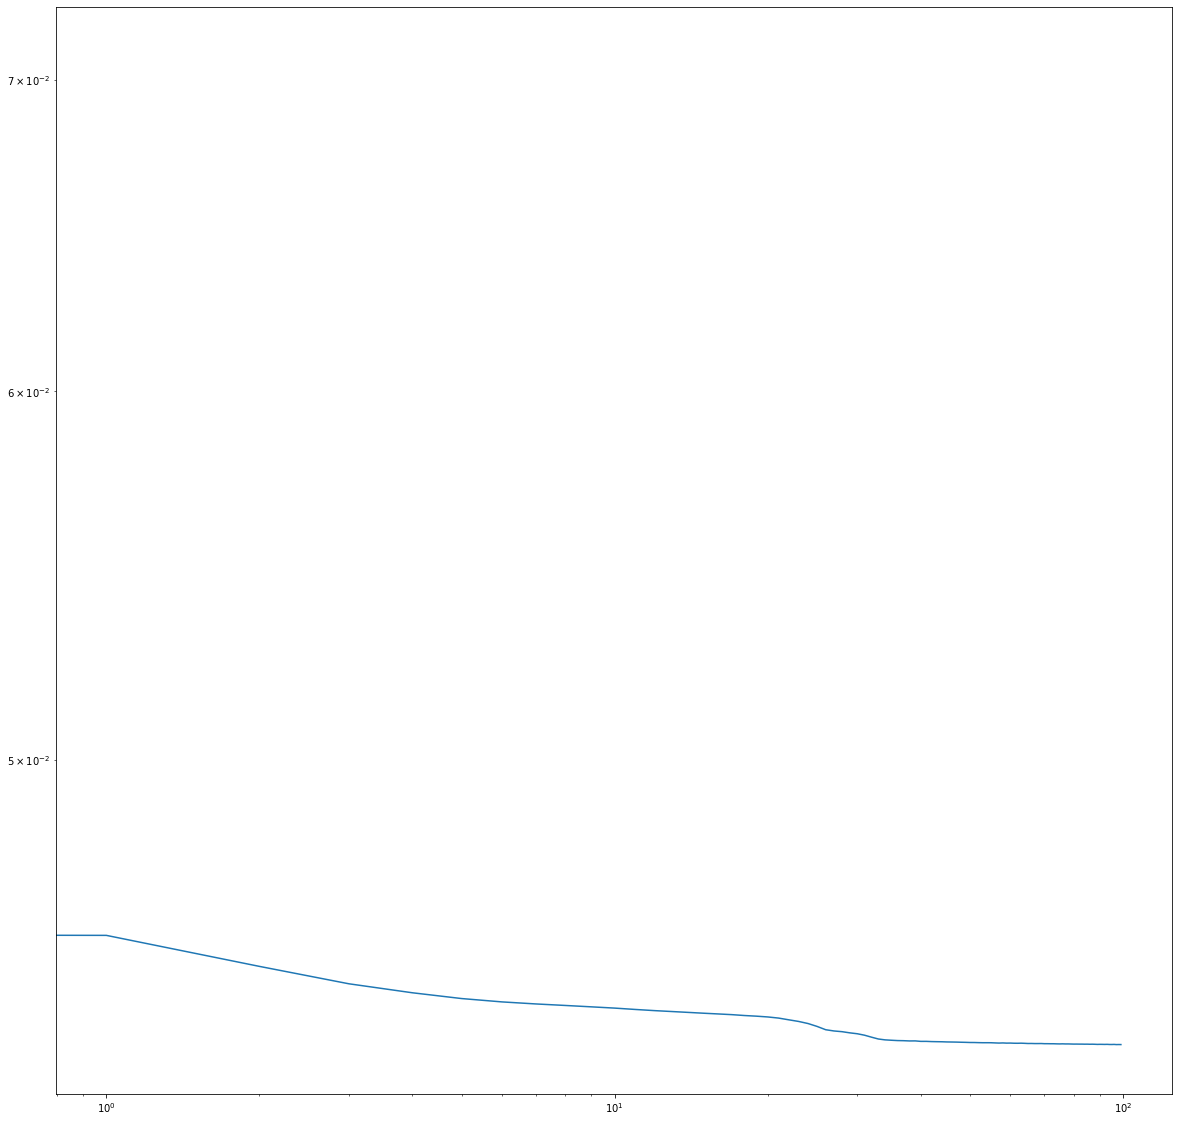

In [12]:

import matplotlib.pyplot as plt
import seaborn as sns
    
#Figure
h,w = 20,20
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
ax1.plot(x,y)
ax1.set_yscale('log')
ax1.set_xscale('log')

In [13]:
#Make some predictions with your model
predictions = model.predict(x_test)

2022-03-28 15:08:18.918622: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3183684380 exceeds 10% of free system memory.
2022-03-28 15:08:20.334489: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3183684380 exceeds 10% of free system memory.


In [14]:
#Lets un-normalise everything so we can deal with nice physical quantities again now all the training is done

display ( (target-target.mean())/target.std() )
display ( (features-features.mean())/features.std() )

0           -0.044207
1           -0.226062
2           -1.234619
3           -1.525317
4           -1.695112
               ...   
105640205   -2.598650
105640206   -2.505777
105640207   -2.517219
105640208   -2.639702
105640209   -2.661450
Name: MODIS_LST, Length: 105640210, dtype: float32

,sp,msl,u10,v10,t2m,aluvp,aluvd,alnip,alnid,cl,...,sdfor,z,sd,sdor,isor,anor,slor,d2m,lsm,fal
0,0.824885,0.461927,-1.205216,-0.846963,0.322145,-0.915294,-0.938750,-0.756101,-0.822101,2.382660,...,-0.055874,-0.717135,-0.160080,1.012439,-0.781426,-1.584791,0.471353,0.994381,-1.754186,-0.880919
1,-0.515831,0.535075,-1.094369,0.023542,0.049545,-0.900179,-0.915626,-0.574112,-0.593238,-0.216455,...,0.447206,0.479093,-0.160080,5.036735,0.571049,-1.320970,2.810580,0.796734,0.244147,-0.770587
2,0.233647,-4.304108,0.846551,-1.500449,-1.069757,-0.538225,-0.520761,-1.000308,-1.073326,2.416619,...,1.469204,-0.603114,-0.130265,2.339700,0.622470,0.605615,1.852094,-0.377136,-1.780295,2.067285
3,0.130655,-4.424923,0.559910,-0.341508,-1.232636,-0.585818,-0.587220,-1.416304,-1.533955,-0.326280,...,2.188998,-0.526783,-0.092272,2.633062,1.347932,1.394265,1.883878,-0.464715,-4.515255,2.990536
4,0.246947,-4.559827,0.761308,-0.396283,-1.112262,-0.551911,-0.546606,-1.371571,-1.473545,-0.326280,...,1.243014,-0.634543,-0.131906,1.801002,-0.457226,-1.367804,1.621544,-0.332159,-6.330323,2.651557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105640205,1.192576,3.617874,-1.616741,0.147387,-2.976827,-0.412388,-0.357177,-0.459001,-0.486068,-0.139965,...,-0.561762,-0.782375,-0.095925,-0.619274,0.577759,0.257187,-0.581931,-2.740834,0.185338,2.806525
105640206,1.221678,3.651450,-1.684811,0.241337,-2.903832,-0.527797,-0.510498,-0.921478,-0.967027,2.411058,...,-0.668740,-0.800322,-0.102058,-0.705676,1.550853,-0.206123,-0.684395,-2.656887,-1.776020,2.759980
105640207,1.237024,3.672136,-1.746636,0.496491,-2.848518,-0.366020,-0.315592,-0.760616,-0.813823,1.468148,...,-0.691159,-0.809602,-0.102422,-0.712611,1.424463,0.275178,-0.708301,-2.558412,-1.051063,2.798796
105640208,1.207696,3.789952,-1.922430,0.660469,-3.089834,-0.665061,-0.632727,-0.528066,-0.560419,-0.200698,...,-0.545349,-0.781986,-0.088902,-0.626434,0.956851,-0.239828,-0.583574,-2.934570,0.232032,2.759386


In [15]:
predictions

array([[-1.9652963],
       [-1.9962769],
       [-1.9779693],
       ...,
       [-2.5648572],
       [-2.7348082],
       [-2.738575 ]], dtype=float32)

In [16]:
predictions_unnormalized = (predictions * target.std() ) + target.mean()

In [17]:
predictions_unnormalized

array([[255.38249],
       [254.72142],
       [255.11208],
       ...,
       [242.58896],
       [238.96251],
       [238.88214]], dtype=float32)

In [18]:
df.columns

Index(['index', 'latitude_ERA', 'longitude_ERA', 'index_MODIS',
       'latitude_MODIS', 'longitude_MODIS', 'band', 'spatial_ref', 'index_ERA',
       'values', 'sp', 'msl', 'u10', 'v10', 't2m', 'number', 'surface',
       'aluvp', 'aluvd', 'alnip', 'alnid', 'cl', 'cvl', 'cvh', 'slt', 'sdfor',
       'z', 'sd', 'sdor', 'isor', 'anor', 'slor', 'd2m', 'lsm', 'fal', 'skt',
       'L2_distance', 'MODIS_idx', 'H_distance', 'time'],
      dtype='object')

In [21]:
#Bring together the test data and predictions into a single pandas df
results_df = df[['latitude_ERA', 'longitude_ERA','time','t2m','skt']]
results_df = results_df[idx_test]

In [22]:
#results_df = results_df.join(y_test)
results_df['pred'] = predictions_unnormalized
results_df['MODIS'] = target[idx_test]
results_df

,latitude_ERA,longitude_ERA,time,t2m,skt,pred,MODIS
71034945,-70.117048,45.75,2020-01-01 10:00:00,258.250977,257.686279,255.382492,255.351456
71034946,-70.117048,47.25,2020-01-01 10:00:00,257.209961,256.631592,254.721420,256.923279
71034947,-70.117048,48.00,2020-01-01 10:00:00,257.432617,256.758545,255.112076,256.583191
71034948,-70.117048,48.75,2020-01-01 10:00:00,257.778320,256.949951,255.483826,259.628265
71034949,-70.117048,49.50,2020-01-01 10:00:00,257.629883,256.662842,255.346985,260.910400
...,...,...,...,...,...,...,...
105640205,70.117048,69.75,2020-12-30 09:00:00,241.386597,240.706482,240.683243,241.867874
105640206,70.117048,71.25,2020-12-30 09:00:00,242.644409,241.774841,241.848663,243.849625
105640207,70.117048,72.00,2020-12-30 09:00:00,243.597534,242.374451,242.588959,243.605469
105640208,70.117048,74.25,2020-12-30 09:00:00,239.439331,238.112732,238.962509,240.991898


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt


def error_plot(df,x,grain):
    
    

    
    
    
    
    #Some new columns used for plotting
    
    
    #Setup the x variable to plot.
    if x == 'time':
        df["X"] = df[x].dt.to_period(grain).dt.to_timestamp()
    else:
        df["X"] = df[x].round(grain) # Can also use .apply(lambda x: custom_round(x, base=2))
    
    
    df['error_ERA'] = abs(df.MODIS - df.skt)
    df['error_NN'] = abs(df.MODIS - df.pred)
    
    
    #Surface some useful numbers
    print("Mean, Median error from NN model:",df.error_NN.mean(), df.error_NN.median())
    print("Mean, Median error from ERA5:    ", df.error_ERA.mean(), df.error_ERA.median())
    
    #Group by
    df_plot = df.groupby(['X'],as_index=False).mean()
    
     #Setup plot env
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    
    #Plot
    p = sns.lineplot(data=df_plot, x='X', y='error_NN',ax=ax1,markers=True,label='NN')
    p = sns.lineplot(data=df_plot, x='X', y='error_ERA',ax=ax1,markers=True,label='ERA')
    
    #Config
    ax1.set_xlabel('time', fontsize = 20)
    ax1.set_ylabel('Error [K]', fontsize = 20)


    

    #Other config
    ax1.legend().set_title(None)
    

    
    

Mean, Median error from NN model: 3.3304212 2.5549622
Mean, Median error from ERA5:     3.7469294 2.9239807
Mean, Median error from NN model: 3.3304212 2.5549622
Mean, Median error from ERA5:     3.7469294 2.9239807


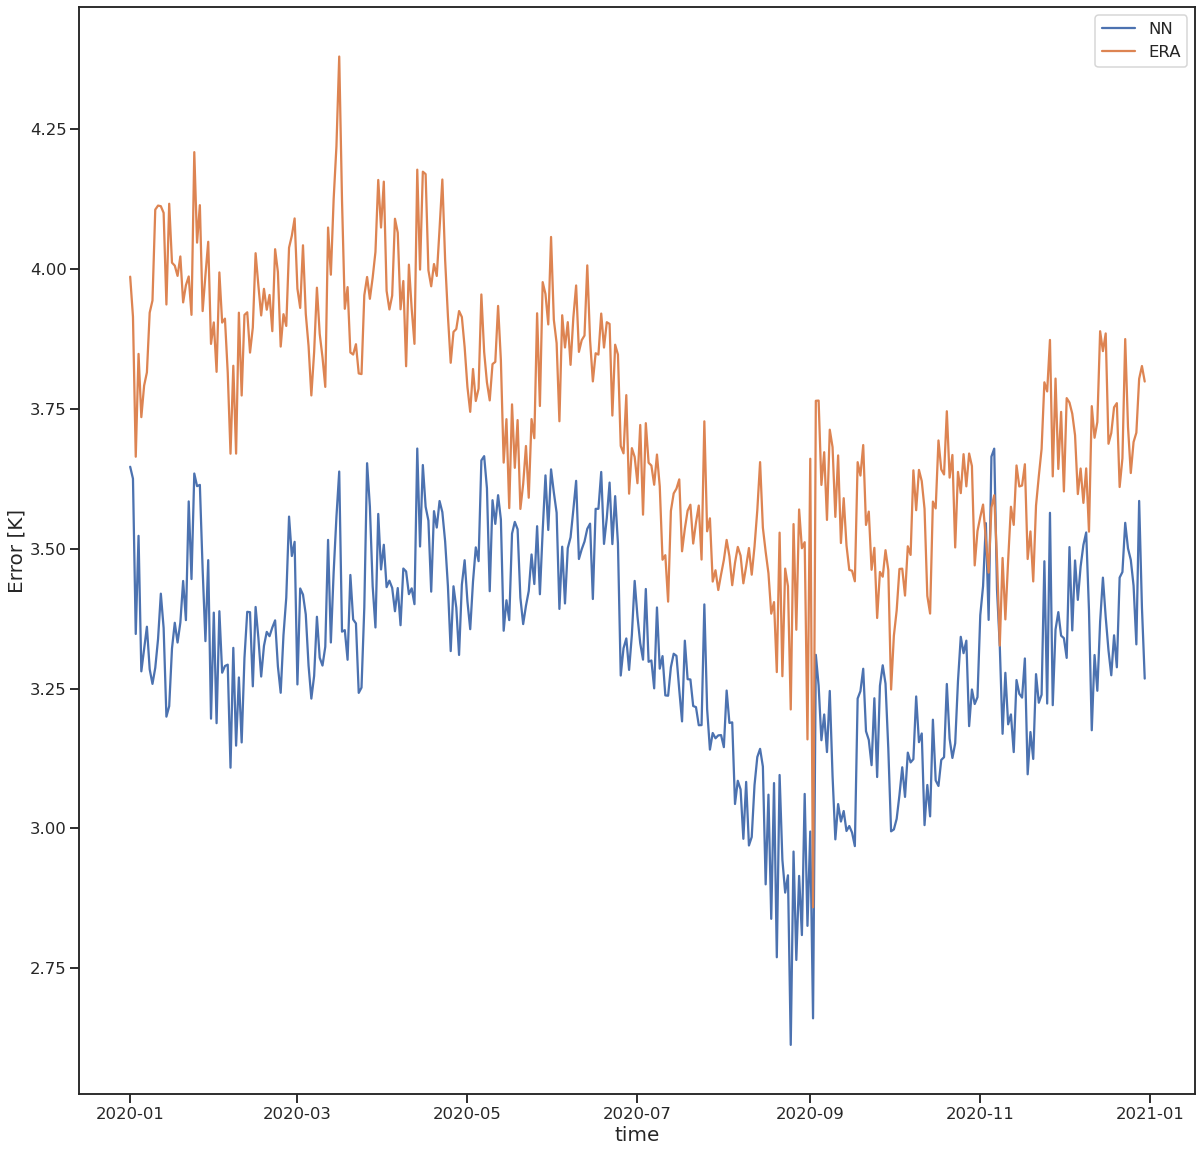

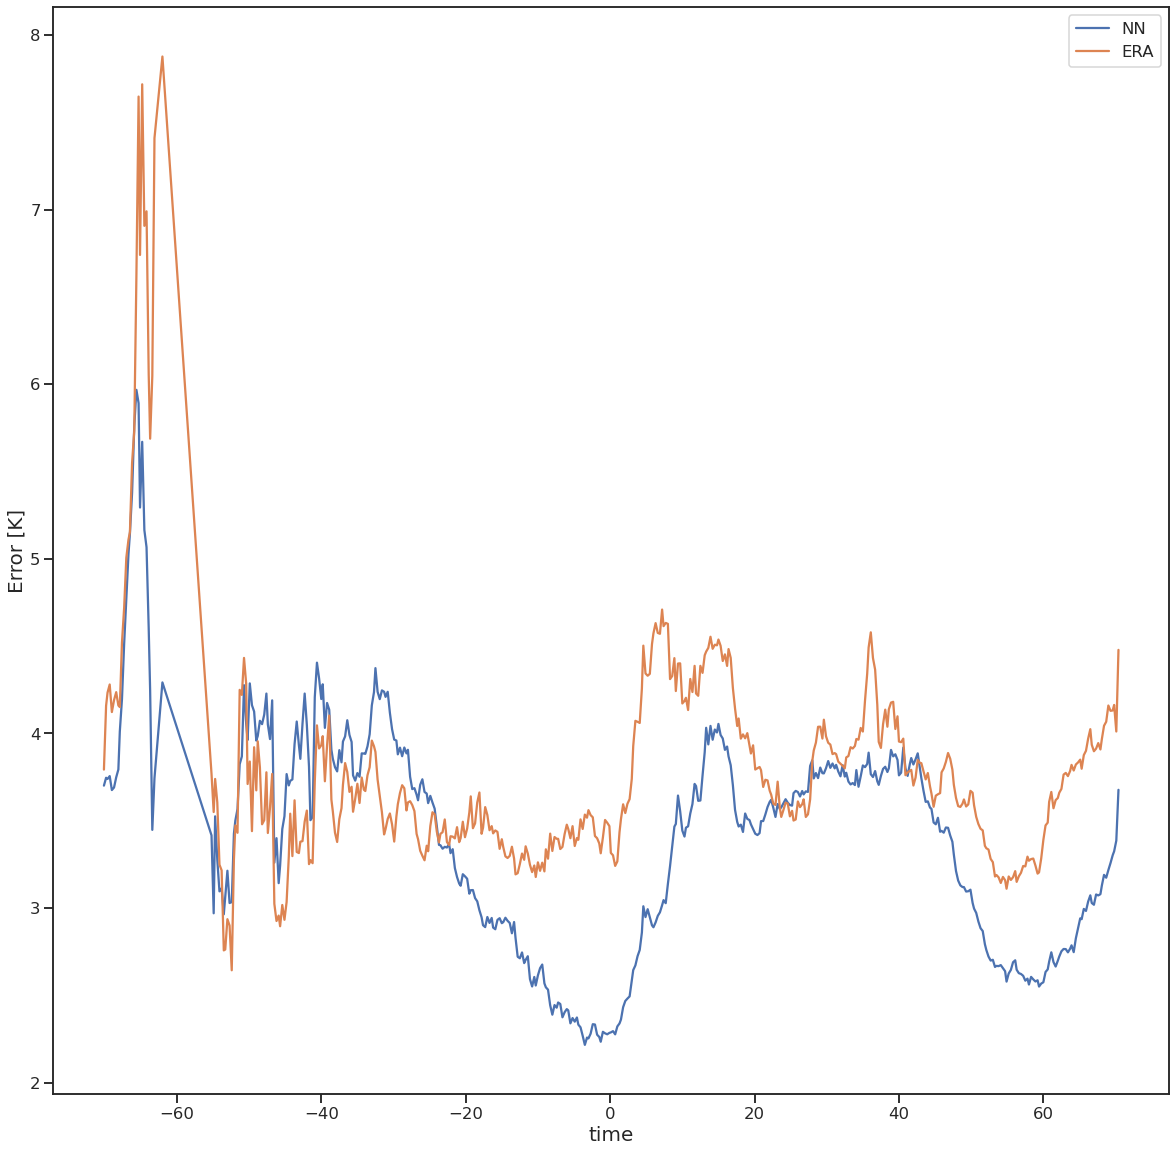

In [24]:
error_plot(results_df,'time','D')
error_plot(results_df,'latitude_ERA',1)

In [98]:
ds_map = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()

In [99]:
ds_map

,latitude_ERA,longitude_ERA,index,index_MODIS,latitude_MODIS,longitude_MODIS,band,spatial_ref,index_ERA,values,...,sdor,isor,anor,slor,d2m,lsm,fal,L2_distance,MODIS_idx,H_distance
0,-70.117048,-75.00,0.000000,230.144923,-69.983333,-75.116038,1.0,0.0,24052.590525,24052.590525,...,91.257812,0.634515,1.103149,0.010839,264.314178,0.784160,0.736108,0.157213,9373.729272,19.814246
1,-70.117048,-74.25,0.885397,765.514969,-69.927531,-74.521735,1.0,0.0,24134.088725,24134.088725,...,8.990723,0.258285,0.067298,0.002234,263.850677,0.998719,0.850002,0.112847,12780.369686,23.523810
2,-70.117048,-72.00,1.476768,97.136869,-69.983333,-71.745438,1.0,0.0,24135.056566,24135.056566,...,21.414185,0.219374,0.300630,0.004086,262.062317,1.000000,0.850002,0.086944,12782.452525,17.846655
3,-70.117048,-71.25,2.170034,112.174350,-69.983333,-71.244188,1.0,0.0,24136.089226,24136.089226,...,98.934570,0.641102,0.104303,0.017063,262.306335,0.998763,0.850002,0.069071,12783.486532,17.066322
4,-70.117048,-70.50,3.022453,134.053292,-69.983333,-70.514890,1.0,0.0,24137.305699,24137.305699,...,137.504150,0.645783,-0.712788,0.023954,262.186676,0.922061,0.850002,0.064002,12784.604491,16.856056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139661,70.117048,157.50,1202.430189,489607.238016,69.983333,157.504265,1.0,0.0,74.000000,74.000000,...,3.664429,0.404829,1.544948,0.000806,259.514557,0.974882,0.471423,0.062989,45.000000,16.829486
139662,70.117048,158.25,1205.793893,489458.214250,69.983333,158.250992,1.0,0.0,75.000000,75.000000,...,2.524292,0.872404,-0.404251,0.000441,259.434967,0.880638,0.474070,0.068306,46.000000,17.048165
139663,70.117048,159.00,1203.652618,488257.373113,69.983333,158.999957,1.0,0.0,76.000000,76.000000,...,6.964355,0.932741,0.884408,0.001147,259.569794,0.667156,0.460619,0.063883,47.000000,16.873870
139664,70.117048,159.75,1208.368290,487683.844438,69.925103,159.589296,1.0,0.0,76.947566,76.947566,...,10.867310,0.470446,-0.909243,0.002232,259.604370,0.678122,0.470494,0.079194,47.980025,22.684405


In [100]:
import geopandas as gpd

def plot_map(ds,x,y,q): #slow plotting function
        
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]))
    
    #Plot the world
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world.boundary.plot(figsize=(24,12))
    
    gdf.plot(ax=ax,column=q,cmap='plasma',markersize=1,legend=True)
    
    
    plt.show()

In [ ]:
plot_map(ds_map,'longitude_ERA', 'latitude_ERA', 't2m')